<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# [Ateliers: Technologies des grosses data](https://github.com/wikistat/Ateliers-Big-Data)

# Données Movielens avec <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a> et [softImpute](https://cran.r-project.org/web/packages/softImpute/index.html)

## 1 Introduction
Le problème de recommandaiton de films est détaillé dans le [calepin](https://github.com/wikistat/Ateliers-Big-Data/tree/master/MovieLens) consacré à Spark et Mllib. C'est un problème de complétion de très grande matrice très creuse. L'objet de ce calepin est de tester la librairie [softImpute](https://cran.r-project.org/web/packages/softImpute/index.html) de R dévolue à la résolution de ce problème. Néanmoins, comme les résultats obtenus ne concurrencent pas ceux de MLlib et sont même assez décevans ([Besse et al. 2016](https://hal.archives-ouvertes.fr/hal-01350099)), ce calepin ne fait que décrire à minima le code de mise en oeuvre de la librairie sur les données MovieLens. 

In [3]:
library(softImpute)

## 2  Etude de la matrice 100k
Le descriptif des données est rechercher dans le [calepin](https://github.com/wikistat/Ateliers-Big-Data/tree/master/MovieLens) écrit en PySpark.

In [4]:
dBrut=read.csv("ratings100k.csv")

In [5]:
dTestInd=sample(nrow(dBrut),nrow(dBrut)/10,replace=FALSE)
dTest=dBrut[dTestInd,1:3]
dTrain=dBrut[-dTestInd,1:3]

In [6]:
dTrainSparse=Incomplete(dTrain$userId,dTrain$movieId,dTrain$rating)
res=softImpute(dTrainSparse,rank.max=4,type="als",lambda=1,maxit=200)
recom=impute(res,dTest[,1],dTest[,2])

In [7]:
sqrt(mean((dTest[,3]-recom)**2))

[1] 1.275422

## 3 Etude de la matrice complète

In [8]:
dBrut=read.csv("ratings20M.csv")

In [9]:
dTestInd=sample(nrow(dBrut),nrow(dBrut)/10,replace=FALSE)
dTest=dBrut[dTestInd,1:3]
nrow(dTest)

[1] 2288437

In [10]:
# sous-échantillonage
dInter=dBrut[-dTestInd,1:3]
taux=1
dTrainInd=sample(nrow(dInter),nrow(dInter)*taux,replace=FALSE)
dTrain=dInter[dTrainInd,1:3]
# Matrice d'échantillonnage spase
dTrainSparse=Incomplete(dTrain$userId,dTrain$movieId,dTrain$rating)

In [11]:
# Factorisation
t1=Sys.time()
res=softImpute(dTrainSparse,rank.max=10,type="als",lambda=20,maxit=200)
t2=Sys.time()
# Reconstruction
recom=impute(res,dTest[,1],dTest[,2])
#RMSE
sqrt(mean((dTest[,3]-recom)**2))
difftime(t2,t1) 

[1] 1.033441

Time difference of 12.20423 mins

Apprentissage avec fichier complet (taux=1): 20M de notes

rang | lambda | temps (') | rmse 
----|---------|-------|-----
 4  |  1       |  5.6 |  1.07   
 10 |  10  |  12.6 |  1.02  
 10 |  20  |  12.2 |  1.033 
 15 |  10  |  19.4 |  1.016
 20 |   1  |  26.9  | 1.02 
 20 |  10  |  26.1  | 1.016 
 20 |  15  |  24.4 |  1.018
 20 |  20  |  27.0  | 1.016 
 30 |  20  |  40.1 |  1.02


In [94]:
recom[recom>5]=5
recom[recom<0]=0

In [95]:
sqrt(mean((dTest[,3]-recom)**2))

[1] 1.011996

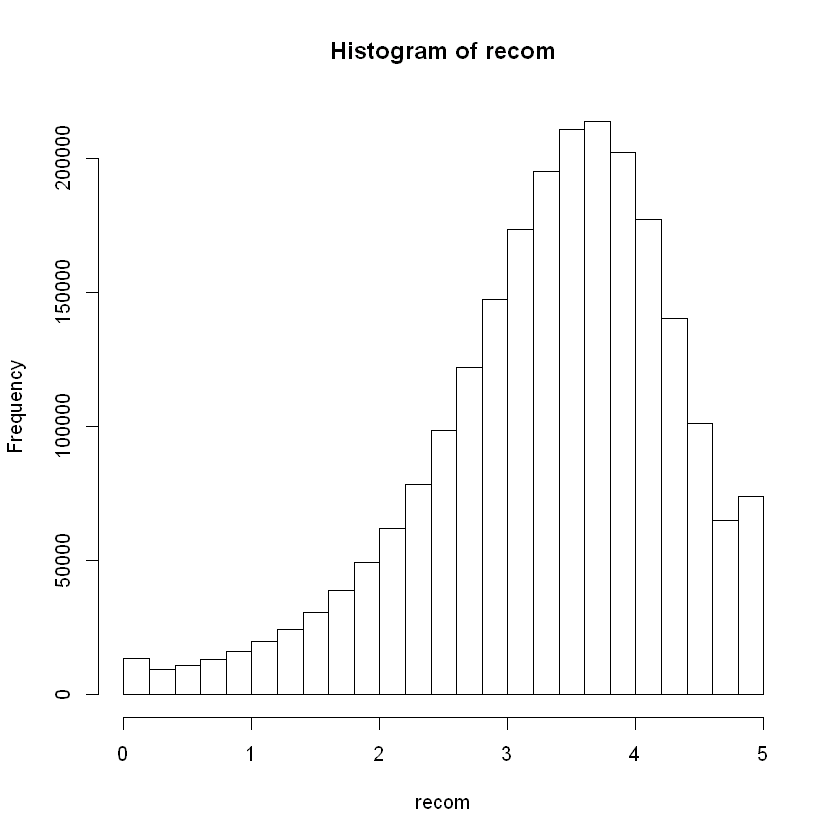

In [96]:
hist(recom)